In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import requests
from PIL import Image

from tqdm import tqdm_notebook
import selenium
import nltk
import seaborn as sns
from tensorflow.keras import preprocessing
from wordcloud import WordCloud, STOPWORDS
from eunjeon import Mecab

import matplotlib.pyplot as plt
%matplotlib inline

## - 데이터 불러오기 및 분석하기

In [3]:
import re
import json
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

df_union = pd.read_csv('./data/dc_db.csv', sep=',', encoding='utf-8', index_col=0)
df_union.head()

,gall_name,cmt_contents,label
0,baseball_new8,ㅠ.ㅠ,0
1,baseball_new8,댓글 지우지?,0
2,baseball_new8,ㅋㅋ,0
3,baseball_new8,설렁설렁해라 - dc App,0
4,baseball_new8,Bcaa함 묵으라,0


In [10]:
print('전체 데이터 개수 : ', len(df_union))

전체 데이터 개수 :  9288


In [11]:
cmt_length = df_union['cmt_contents'].astype(str).apply(len)
cmt_length.head()

0     3
1     7
2     2
3    16
4     9
Name: cmt_contents, dtype: int64

Text(0, 0.5, 'Number of review')

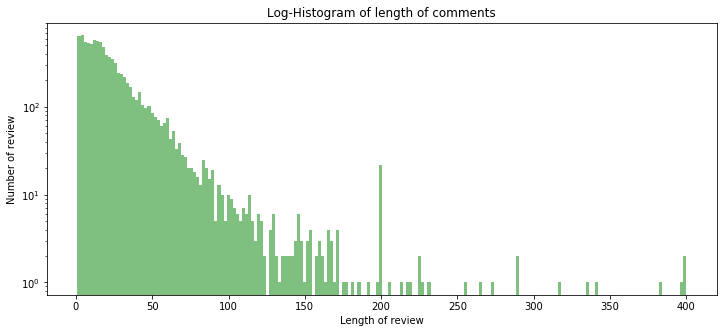

In [12]:
# 그래프
plt.figure(figsize=(12,5))
plt.hist(cmt_length, bins=200, alpha=0.5, color='g', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of comments')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [13]:
print('댓글 길이 최댓값 ', np.max(cmt_length))
print('댓글 길이 최솟값 ', np.min(cmt_length))
print('댓글 길이 평균값 ', np.mean(cmt_length))
print('댓글 길이 표준편차 ', np.std(cmt_length))
print('댓글 길이 중간값 ', np.median(cmt_length))
print('댓글 길이 제1사분위 ', np.percentile(cmt_length, 25))
print('댓글 길이 제3사분위 ', np.percentile(cmt_length, 75))

댓글 길이 최댓값  400
댓글 길이 최솟값  1
댓글 길이 평균값  24.163113695090438
댓글 길이 표준편차  27.279082661558686
댓글 길이 중간값  17.0
댓글 길이 제1사분위  8.0
댓글 길이 제3사분위  30.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1cb98ddf518>,
 'caps': [<matplotlib.lines.Line2D at 0x1cb98ddfbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cb98ddf2e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1cb98de82b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cb98de8908>],
 'means': [<matplotlib.lines.Line2D at 0x1cb98de85f8>]}

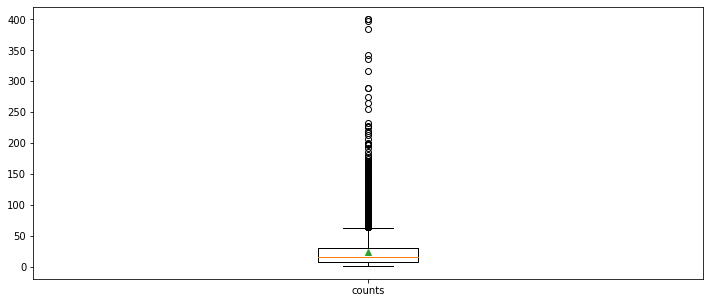

In [14]:
plt.figure(figsize=(12,5))
plt.boxplot(cmt_length, labels=['counts'], showmeans=True)

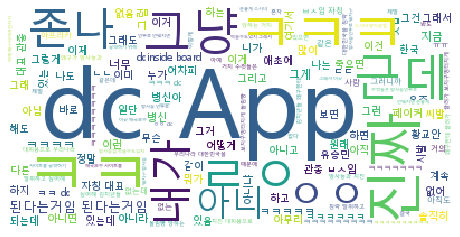

In [15]:
path = 'c:/Windows/Fonts/malgun.ttf'

train_cmt = [cmt for cmt in df_union['cmt_contents'] if type(cmt) is str]
wordcloud = WordCloud(font_path=path,
                      relative_scaling=0.5,
                      background_color = 'white').generate(' '.join(train_cmt))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

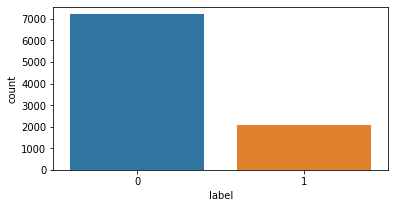

In [16]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(df_union['label'])

In [17]:
print('욕설 댓글 개수', df_union['label'].value_counts()[1])
print('욕설이 아닌 댓글 개수', df_union['label'].value_counts()[0])

욕설 댓글 개수 2089
욕설이 아닌 댓글 개수 7199


Text(0.5, 0, 'Number of comments')

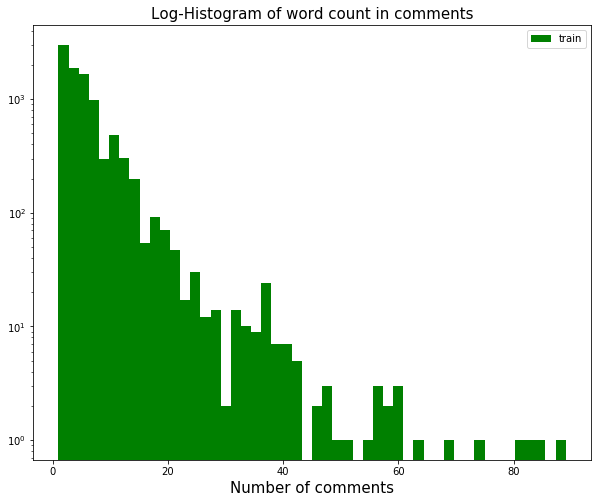

In [18]:
word_counts = df_union['cmt_contents'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(10, 8))
plt.hist(word_counts, bins=50, facecolor='g', label='train')
plt.title('Log-Histogram of word count in comments', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.xlabel('Number of comments', fontsize=15)

In [19]:
print('댓글 단어 개수 최댓값 ', np.max(word_counts))
print('댓글 단어 개수 최솟값 ', np.min(word_counts))
print('댓글 단어 개수 평균값 ', np.mean(word_counts))
print('댓글 단어 개수 표준편차 ', np.std(word_counts))
print('댓글 단어 개수 중간값 ', np.median(word_counts))
print('댓글 단어 개수 제1사분위 ', np.percentile(word_counts, 25))
print('댓글 단어 개수 제3사분위 ', np.percentile(word_counts, 75))

댓글 단어 개수 최댓값  89
댓글 단어 개수 최솟값  1
댓글 단어 개수 평균값  5.636843238587424
댓글 단어 개수 표준편차  5.973906729359337
댓글 단어 개수 중간값  4.0
댓글 단어 개수 제1사분위  2.0
댓글 단어 개수 제3사분위  7.0


## - 데이터 전처리

In [20]:
def preprocessing(data, mecab, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    words = mecab.morphs(data_text)    
    if remove_stopwords:
        words = [token for token in words]

    return words

In [21]:
mecab = Mecab()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

clean_cmt = []

In [22]:
for review in tqdm_notebook(df_union['cmt_contents']):
    if type(review) == str:
        clean_cmt.append(preprocessing(review, mecab, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        clean_cmt.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_cmt)
train_sequences = tokenizer.texts_to_sequences(clean_cmt)
word_vocab = tokenizer.word_index

In [24]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

In [25]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data/word_dict/input.npy', 'wb'), train_inputs)
np.save(open('./data/word_dict/label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data/word_dict/data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

## 형태소 정보 추가 

In [4]:
mecab = Mecab()

def tokenize(doc):
    return ['/'.join(t) for t in mecab.pos(doc)]

In [6]:
print(len(df_union))
print(df_union.iloc[1, 1])
print(df_union.iloc[1, -1])

9288
댓글 지우지?
0


In [7]:
def pos_preprocessing(data, mecab, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    #words = mecab.morphs(data_text)
    words = tokenize(data_text)
    if remove_stopwords:
        words = [token for token in words]

    return words

In [8]:
mecab = Mecab()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

docs = []

for review in tqdm_notebook(df_union['cmt_contents']):
    if type(review) == str:
        docs.append(pos_preprocessing(review, mecab, remove_stopwords=False,
                                                stop_words=stop_words))
    else:
        docs.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
train_sequences = tokenizer.texts_to_sequences(docs)
word_vocab = tokenizer.word_index

In [12]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data/word_dict/pos_input.npy', 'wb'), train_inputs)
np.save(open('./data/word_dict/pos_label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data/word_dict/pos_data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

In [13]:
docs

[['ㅠㅠ/UNKNOWN'],
 ['댓글/NNG', '지우/VV', '지/EC'],
 ['ㅋㅋ/IC'],
 ['설렁설렁/MAG', '해라/VV+EC'],
 ['함/MAG', '묵/VV', '으라/EC'],
 ['자/VV', '지/EC', '마/VX', '라/EC'],
 ['피부/NNG', '원/NNG', '툴/NNP'],
 ['야리/NNP', '둡/NNP', '후덕/NNG', '해졌/XSA+EC+VX+EP', '노/EF', 'ㅋㅋ/IC'],
 ['피부/NNG', '도/JX', '르/NNG', '수상/NNG', 'ㅋㅋㅋ/IC'],
 ['왜/MAG',
  '냐/VCP+EF',
  '즈그/NP',
  '아들/NNG',
  '딸/NNG',
  '들/XSN',
  '은/JX',
  '이미/MAG',
  '졸업/NNG',
  '했/XSV+EP',
  '기/ETN',
  '때문/NNB'],
 ['ㅇㅈ/UNKNOWN', 'ㅋㅋㅋ/IC', 'ㅋㅋ/IC', '리얼/NNG', '재앙/NNG'],
 ['퍄퍄/UNKNOWN', '내향성/NNG', '갤러리/NNG', 'ㄱ/NNG', 'ㄱ/NNG'],
 ['ㅋㅋㅋ/IC', 'ㅋㅋ/IC', '시발/NNG'],
 ['남자/NNG',
  '새끼/NNG',
  '지인/NNG',
  '인데/VCP+EC',
  '도/JX',
  '그냥/MAG',
  '도망가/VV',
  '네/EC'],
 ['시발/NNG', '새끼/NNG'],
 ['시/NNG', '발련/NNG', '아/JKV'],
 ['나/VA', '은/ETM', '아씨/NNG', '는/JX', 'ㅇㅈ이지/UNKNOWN'],
 ['노/NNP', '잼/NNG'],
 [],
 ['ㅋㅋㅋ/IC'],
 ['지랄/NNG', 'ㅋㅋ/IC'],
 ['퍄/UNKNOWN'],
 ['그걸/NP+JKO', '왜/MAG', '붙여/VV+EC', 'ㅋㅋㅋ/IC', 'ㅋㅋ/IC'],
 ['ㄹ/JKO', 'ㅇ/UNKNOWN'],
 ['ㄹ/JKO', 'ㅇ/UNKNOWN', '흠/NNG', '흠/NNG'],
 ['닮/VV',